In [ ]:
# Run in Colab to install local packages
!pip install datasets gensim sentence_transformers tqdm

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

import datasets

In [2]:
sciq = datasets.load_dataset("allenai/sciq")

In [3]:
train = sciq["train"]

In [8]:
print(train[0])

{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


In [44]:
inference = pd.read_csv("inference_quantitative_analysis.tsv", sep="\t", header=0)

In [45]:
inference

,id,case,support,answer,question,distractor1,distractor2,distractor3
0,0,ground_truth,Oxidants and Reductants Compounds that are cap...,oxidants,Compounds that are capable of accepting electr...,antioxidants,Oxygen,residues
1,0,answer_given,Oxidants and Reductants Compounds that are cap...,oxidants,What are compounds that are capable of accepti...,acids,enzymes,reductants
2,1,ground_truth,But transgenic animals just have one novel gen...,clone,What term in biotechnology means a genetically...,adult,male,phenotype
3,1,answer_given,But transgenic animals just have one novel gen...,clone,What is a genetically exact copy of an organis...,replica,duplicate,replica
4,2,ground_truth,Figure 29.7 Vertebrata are characterized by th...,backbone,Vertebrata are characterized by the presence o...,Bones,Muscles,Thumbs
...,...,...,...,...,...,...,...,...
1756,996,answer_given,"Short-period comets come from the Kuiper belt,...",kuiper belt,Where do short-period comets come from?,Oort cloud,Kuiper-Oort cloud,Kuiper-Kuiper cloud
1757,998,ground_truth,Atoms with unstable nuclei are radioactive. To...,radioactive,What are atoms with unstable nuclei are consid...,ions,unstable,destructive
1758,998,answer_given,Atoms with unstable nuclei are radioactive. To...,radioactive,Atoms with unstable nuclei are what?,toxic,radioactive,unstable
1759,999,ground_truth,"On land, sulfur is deposited in four major way...",sulfur dioxide (so2),In what form is atmospheric sulfur found?,formaldehyde,sulfuric acid,sulfur monoxide


## Length of answers and distractors

In [4]:
def get_max_length(sample):
    return {
        "max_length": max(
            [len(sample[y].split(" ")) for y in ["correct_answer", "distractor1", "distractor2", "distractor3"]]
        )
    }


train = train.map(get_max_length, remove_columns=["question", "support"])

In [42]:
train_df = train
train_df.set_format("pandas")
train_df = train_df[:]
train_df["len_correct_answer"] = train_df["correct_answer"].apply(lambda x: len(x.split(" ")))
# train_df["max_len"] = train.map(lambda x: max([len(x[y].split(" ")) for y in ["correct_answer", "distractor1", "distractor2", "distractor3"]]))

frequencies = (
    #     train_df["len_correct_answer"]
    bla["max_length"].value_counts().to_frame().reset_index()
    #     .rename(columns={"index": "number of words", "len_correct_answer": "frequency"})
)
train.set_format()
frequencies

,index,max_length
0,1,6204
1,2,4018
2,3,1142
3,4,196
4,5,64
5,6,26
6,7,14
7,8,5
8,9,3
9,10,3


## Word embeddings

In [6]:
# fasttext = gensim.downloader.load("fasttext-wiki-news-subwords-300")
# fasttext = gensim.models.KeyedVectors.load("ft") #, mmap='r'

In [7]:
print(fasttext.similarity("viruses", "protozoa"))
print(fasttext.similarity("protozoa", "viruses"))

0.52428013
0.52428013


In [9]:
small = train.select([i for i in range(10)])
print(small)
print(small[0])

Dataset({
    features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
    num_rows: 10
})
{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


In [63]:
ansToDist = []
distToDist = []
for i, sample in enumerate(train):
    if sample["max_length"] > 1:
        continue
    try:
        sim = [
            fasttext.similarity(sample["correct_answer"], sample[distractor])
            for distractor in ["distractor1", "distractor2", "distractor3"]
        ]
        ansToDist.extend(sim)
        if max(sim) >= 1.0:
            print(i)
        sim = [
            fasttext.similarity(sample["distractor" + str(a)], sample["distractor" + str(b)])
            for a, b in [(1, 2), (1, 3), (2, 3)]
        ]
        distToDist.extend(sim)
    except KeyError:
        continue

1481
4997
5387
5558
11108
11116


In [48]:
len(ansToDist)

17109

In [54]:
ansToDistDF = pd.DataFrame(ansToDist)
ansToDistDF.describe()

,0
count,17109.000000
mean,0.511500
std,0.141269
min,-0.056659
25%,0.420177
50%,0.496206
75%,0.589245
max,1.000000


In [53]:
distToDistDF = pd.DataFrame(distToDist)
distToDistDF.describe()

,0
count,17109.000000
mean,0.469450
std,0.139733
min,-0.020514
25%,0.377366
50%,0.456741
75%,0.544530
max,1.000000


In [57]:
npAnsToDist = np.array(ansToDist)

(array([  11.,   39.,  323., 1806., 4843., 5349., 2962., 1074.,  341.,
         361.]),
 array([-0.05665937,  0.04900656,  0.1546725 ,  0.26033843,  0.36600438,
         0.4716703 ,  0.57733625,  0.6830022 ,  0.7886681 ,  0.8943341 ,
         1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

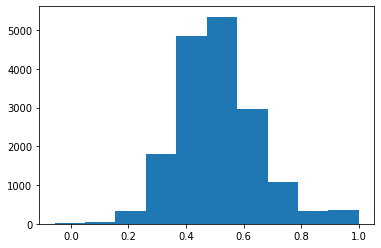

In [69]:
plt.hist(npAnsToDist, bins=10)

(array([  13.,  137.,  987., 3686., 5565., 3900., 1762.,  622.,  194.,
         243.]),
 array([-0.02051357,  0.08153778,  0.18358915,  0.2856405 ,  0.38769186,
         0.4897432 ,  0.59179455,  0.6938459 ,  0.7958973 ,  0.8979486 ,
         1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

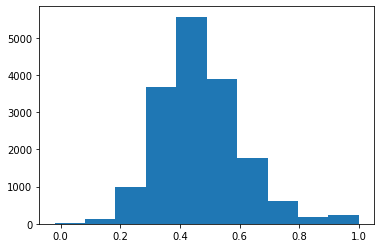

In [70]:
plt.hist(distToDist, bins=10)

## Sentence embeddings

In [5]:
model = SentenceTransformer(
    "all-mpnet-base-v2"
)  # See for other pretrained models: https://www.sbert.net/docs/pretrained_models.html

In [8]:
sample = train[0]
strings_to_encode = [sample[j] for j in keys_to_encode]
embeddings = {key: value for key, value in zip(keys_to_encode, model.encode(strings_to_encode), strict=False)}

In [25]:
bla = []
sim1 = [
    util.cos_sim(embeddings["correct_answer"], embeddings[distractor])
    for distractor in ["distractor1", "distractor2", "distractor3"]
]
print(sim1)
sim2 = util.cos_sim(
    embeddings["correct_answer"],
    np.array([embeddings[distractor] for distractor in ["distractor1", "distractor2", "distractor3"]]),
)
print(sim2)
print(sim2.numpy())
bla.extend(sim2.numpy()[0])
print(bla)

[tensor([[0.4363]]), tensor([[0.2316]]), tensor([[0.1706]])]
tensor([[0.4363, 0.2316, 0.1706]])
[[0.43632895 0.23158763 0.17062837]]
[0.43632895, 0.23158763, 0.17062837]


In [36]:
ansToDist = []
distToDist = []
lowAnsToDistSimIndices = []
lowDistToDistSimIndices = []

keys_to_encode = ["correct_answer", "distractor1", "distractor2", "distractor3"]
for i, sample in enumerate(tqdm(train)):
    strings_to_encode = [sample[j] for j in keys_to_encode]
    embeddings = {key: value for key, value in zip(keys_to_encode, model.encode(strings_to_encode), strict=False)}

    #     sim = [util.cos_sim(embeddings["correct_answer"], embeddings[distractor]) for distractor in ["distractor1", "distractor2", "distractor3"]]
    sim = util.cos_sim(
        embeddings["correct_answer"],
        np.array([embeddings[distractor] for distractor in ["distractor1", "distractor2", "distractor3"]]),
    )
    sim = sim.numpy()[0]
    if min(sim) <= 0.0:
        lowAnsToDistSimIndices.append(i)
    ansToDist.extend(sim)

    sim = [
        util.cos_sim(embeddings["distractor" + str(a)], embeddings["distractor" + str(b)]).item()
        for a, b in [(1, 2), (1, 3), (2, 3)]
    ]
    if min(sim) <= 0.0:
        lowDistToDistSimIndices.append(i)
    distToDist.extend(sim)

# ansToDist = [tensor.item() for tensor in ansToDist]
# distToDist = [tensor.item() for tensor in distToDist]

100%|██████████| 11679/11679 [04:36<00:00, 42.25it/s]


In [41]:
print([train[i] for i in lowAnsToDistSimIndices])
print([train[i] for i in lowDistToDistSimIndices])

[{'distractor3': 'the same', 'distractor1': 'neither', 'distractor2': 'low frequency waves', 'correct_answer': 'high frequency waves', 'max_length': 3}, {'distractor3': 'food chains', 'distractor1': 'biomes', 'distractor2': 'spontaneous mutation', 'correct_answer': 'ecological pyramids', 'max_length': 2}, {'distractor3': 'storage capacity', 'distractor1': 'heat regulation', 'distractor2': 'potentiation', 'correct_answer': 'space efficiency', 'max_length': 2}, {'distractor3': 'osmosis', 'distractor1': 'sporozoans', 'distractor2': 'fluctuations', 'correct_answer': 'plasmolysis', 'max_length': 1}, {'distractor3': 'step impact or bending', 'distractor1': 'overuse', 'distractor2': 'spiral impact or bending', 'correct_answer': 'sideways impact or bending', 'max_length': 4}, {'distractor3': 'life cycle', 'distractor1': 'minute race', 'distractor2': 'slowing rate', 'correct_answer': 'development fate', 'max_length': 2}, {'distractor3': 'the ozone layer', 'distractor1': 'solar winds', 'distract

In [37]:
ansToDistDF = pd.DataFrame(ansToDist)
ansToDistDF.describe()

,0
count,35037.000000
mean,0.455076
std,0.179614
min,-0.083836
25%,0.321572
50%,0.439873
75%,0.580109
max,1.000000


In [38]:
distToDistDF = pd.DataFrame(distToDist)
distToDistDF.describe()

,0
count,35037.000000
mean,0.410491
std,0.174615
min,-0.073038
25%,0.278083
50%,0.393122
75%,0.529450
max,1.000000


(array([  46.,  619., 3298., 6856., 7915., 6890., 4870., 2987., 1297.,
         259.]),
 array([-0.08383643,  0.02454724,  0.1329309 ,  0.24131457,  0.34969824,
         0.4580819 ,  0.56646557,  0.67484924,  0.7832329 ,  0.89161657,
         1.00000024]),
 <BarContainer object of 10 artists>)

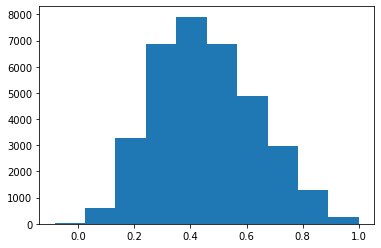

In [43]:
plt.hist(ansToDist, bins=10)

(array([  98., 1256., 5273., 8171., 7531., 5951., 4041., 1937.,  625.,
         154.]),
 array([-0.07303758,  0.0342662 ,  0.14156998,  0.24887377,  0.35617755,
         0.46348133,  0.57078511,  0.67808889,  0.78539267,  0.89269646,
         1.00000024]),
 <BarContainer object of 10 artists>)

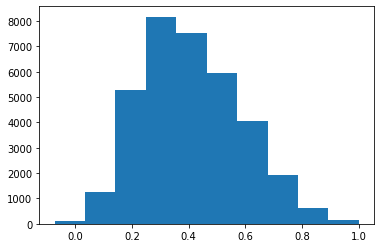

In [44]:
plt.hist(distToDist, bins=10)

## Old code

In [7]:
def get_similarities(sample):
    if len(sample["correct_answer"].split(" ")) > 1:
        return {
            "correct_to_distractor": [None],
            "distractor_to_distractor": [None],
        }
    try:
        return {
            "correct_to_distractor": [
                fasttext.similarity(sample["correct_answer"], sample[distractor])
                for distractor in ["distractor1", "distractor2", "distractor3"]
            ],
            "distractor_to_distractor": [
                fasttext.similarity(sample["distractor" + str(a)], sample["distractor" + str(b)])
                for a, b in [(1, 2), (1, 3), (2, 3)]
            ],
        }
    except KeyError:
        return {
            "correct_to_distractor": [None],
            "distractor_to_distractor": [None],
        }

### Finding bad samples

In [ ]:
np.argmax(npAnsToDist)
train[1481]